### Import mujoco and numpy

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class HopperDynamics(object):
    def __init__(self, dt=0.05) -> None:
        self._m  = 0.1
        self._I = np.diag([.01, .01, .01])
        self._Iinv = np.linalg.inv(self._I)
        self._g  = np.array([0.,0.,9.81])
        self._dt = dt

        def dfdt(x, lam, foot_pose):
            pddot = - self._g
            thddot = 0.0
            p, pdot = x[:6], x[6:]
            for i in range(4):
                pddot = pddot + lam[i*3:i*3+3]/self._m 
                thddot = thddot + self._Iinv@ca.cross(foot_pose[i*3:i*3+3], lam[i*3:i*3+3])
            return ca.vertcat(pdot, pddot, thddot) 
        def f(x, u, p):
            return x + self._dt * self.dfdt(x, u, p)
        self.dfdt = dfdt 
        self.f = f 

hopper_model = HopperDynamics()
tf = 1
N = int(tf/hopper_model._dt)
def loss(x, u):
    J = 0.0
    xd = ca.DM([0., 0., 1.])
    for t in range(N):
        # J = J + ca.sumsqr(x[:3,t]-xd) + 0.001*ca.sumsqr(x[3:,t])#+ 10*(x[1,t]-vd)**2
        J=J+ca.sumsqr(x[2,t]-1.0) + 0.1*ca.sumsqr(x[6,t]-0.1)
    J = J +  ca.sumsqr(x[2,t]-1.0) #+ 0.001*ca.sumsqr(x[3:,t])
    return J/float(N)

def phi(x, p):
    return x[2]-p[2]

In [3]:
opti = ca.Opti()

# Decision variables for state trajetcory
# xyz rpy
x    = opti.variable(12, N+1)
# foot poses and contact forces

lam = opti.variable(3*4, N)
foot_poses = opti.variable(3*4, N)

# lam  = opti.variable(3, N)
# p    = opti.variable(3, N)
x_init  = opti.parameter(12, 1)  # initial cond Parameter (not optimized over)
# pf = opti.parameter(2,1)
opti.minimize(loss(x,lam))

for k in range(N):
  opti.subject_to(x[:,k+1]==hopper_model.f(x[:,k],lam[:,k], foot_poses[:,k]))
  # opti.subject_to(hopper_model.manip_eq(x[:,k+1],x[:,k],u[:,k])==0)
  for i in range(4):
    opti.subject_to(phi(x[:,k], foot_poses[i*3:i*3+3,k])>=0)
    opti.subject_to(phi(x[:,k], foot_poses[i*3:i*3+3,k])*lam[i*3:i*3+3,k]<=0.01)
    lam_v = lam[i*3:i*3+3,k]
    opti.subject_to(lam_v[2] >= 0)
    opti.subject_to(lam_v[0]**2+lam_v[1]**2 <= (0.8*lam_v[2])**2)
  # opti.subject_to(opti.bounded(-2, p[0,k], 2))
  # opti.subject_to(u[1,k]<=0)

opti.subject_to(opti.bounded(-1, foot_poses, 1))
# opti.subject_to(opti.bounded(-1,u[1,:],1))
opti.subject_to(x[:,0]==x_init) #np.array([2.,0.]))
# opti.subject_to(u>=0)
# opti.subject_to(x[:,-1]==pf) #np.array([10.,0.]))


In [4]:
p_opts = {"expand": True}
s_opts = {"print_level":0, "max_iter": 1000, "acceptable_tol": 1e-3, "acceptable_obj_change_tol":1e-7, "tol":1e-8, "slack_bound_push": 0.1, "slack_bound_frac":0.5}
opti.solver('ipopt', p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(x_init, [0.1,0.4, 0.5]+ [0.01]*3+[0.]*6)
# opti.set_value(pf, [1.1 ,0.])
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 201.00us (  1.31us) 188.70us (  1.23us)       154
       nlp_g  |   1.78ms ( 11.55us)   1.42ms (  9.22us)       154
    nlp_grad  |  24.00us ( 24.00us)  24.17us ( 24.17us)         1
  nlp_grad_f  | 369.00us (  2.38us) 335.91us (  2.17us)       155
  nlp_hess_l  | 909.00us (  5.94us) 877.58us (  5.74us)       153
   nlp_jac_g  |   3.00ms ( 19.34us)   3.01ms ( 19.45us)       155
       total  | 751.40ms (751.40ms) 761.19ms (761.19ms)         1


In [5]:
(x,lam, pf) = (sol.value(x).T, sol.value(lam).T, sol.value(foot_poses).T)

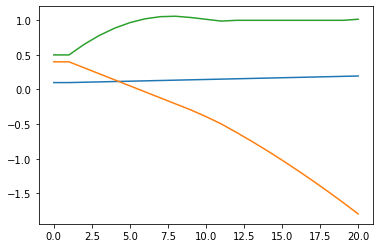

In [6]:
# plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)
plt.plot(x[:,:3])
# plt.plot(x[:,0], x[:,1])
# plt.plot(t/hopper_model._dt, 2*np.sin(t * 2*2 * np.pi)+2)
# plt.plot(lam[:])

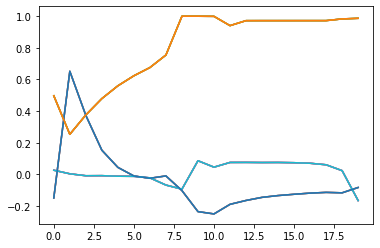

In [7]:
plt.plot(pf)